## Principle Component Analysis and Dimension Reduction

#### By: Kuan-Lin Chen
#### Last edited: 2021/08/31

### Why do we need dimension reduction?

The idea - "big data", with large amount of features to train for, may not be best in most scenarios, due to serval reasons:

1. Some (if not most) features may be of no importance and are mostly noises
2. These extra feature are a burden to the training process, rendering it slow and inaccuarte
3. Also increases the risk of over-fitting as we're mostly fitting to noises

**Thus, reducing dimension is an important preprocessing treatment, can highly increase the efficiency and accuracy of the model training process.**

4. Also, **Dimension Reduction is also extremely useful in data visualization**

---

In this notebook, we will be learning:

1. **PCA** - the most popular dimension reduction method
2. **Randomized PCA** - PCA with stochastic algorithm for **acceleration**
3. **Incremental PCA** - Doing PCA in mini-batch, useful when **low on memeory**

In [1]:
# import packages
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# plotting set-up
plt.rc('font', family = 'serif', size = 13, weight = "bold")
# My Set-Up
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
# Sam's Set-Up
# plt.rc('xtick', labelsize = 10, direction = 'in', top = 'on')
# plt.rc('xtick.major', size = 5, width = 2)
# plt.rc('ytick', labelsize = 10, direction = 'in', right = 'on')
# plt.rc('ytick.major', size = 5, width = 2)
plt.rc('axes', linewidth = 2)
plt.rc('lines', linewidth = 3)
plt.rc('figure', figsize = (6, 6))
plt.rc('legend', fontsize = 13)

cm = plt.cm.get_cmap('tab20')

## Principle Component Analysis

PCA, a.k.a Principle Component Analysis is a popular dimension reduction method for identifying important features from data. **It locates and projects data to the hyper-plane closest to the data.**

We will start with **generating some 3d sample dataset.**

In [3]:
# generate sample data
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

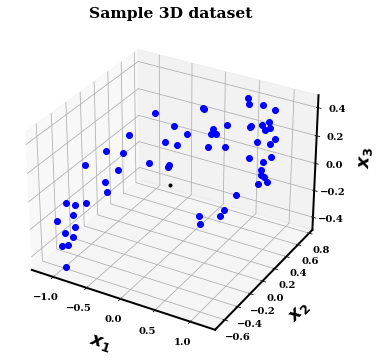

In [8]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection = '3d')

ax.plot(X[:, 0], X[:, 1], X[:, 2], "bo")
ax.plot([0], [0], [0], "k.")

ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)

plt.title("Sample 3D dataset", weight = "bold")

plt.show()

We will be using ```scikit-learn``` package to do PCA, projecting the 3d data on a 2d plane.

In [9]:
from sklearn.decomposition import PCA

In [10]:
help(PCA)

Help on class PCA in module sklearn.decomposition._pca:

class PCA(sklearn.decomposition._base._BasePCA)
 |  PCA(n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
 |  
 |  Principal component analysis (PCA).
 |  
 |  Linear dimensionality reduction using Singular Value Decomposition of the
 |  data to project it to a lower dimensional space. The input data is centered
 |  but not scaled for each feature before applying the SVD.
 |  
 |  It uses the LAPACK implementation of the full SVD or a randomized truncated
 |  SVD by the method of Halko et al. 2009, depending on the shape of the input
 |  data and the number of components to extract.
 |  
 |  It can also use the scipy.sparse.linalg ARPACK implementation of the
 |  truncated SVD.
 |  
 |  Notice that this class does not support sparse input. See
 |  :class:`TruncatedSVD` for an alternative with sparse data.
 |  
 |  Read more in the :ref:`User Guide <PCA>`.
 |  
 | 

In [11]:
# reduce to 2d data, n_components = 2
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

#### tips: data can be retrieved via the ```inverse_transform``` function

In [12]:
X3D_inv = pca.inverse_transform(X2D)

### Eigenvector

We can find the principle component axis (PC1, PC2, ...) in ```pca.components_``` for the **singular vector (Eigenvector)** 

In [13]:
# PCA objects: PC1, PC2
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

### Scree Plot

Scree plot is a graph demonstrating **the percentage of variation each PC accounts for**, and can be used to measure or determine, whether we need more PCs.

These values are stored in ```pca.explained_variance_ratio_```

In [16]:
pca.explained_variance_ratio_ 

array([0.84248607, 0.14631839])

#### *PC1 accounts for 84.28%, PC2 accounts for 14.63%*

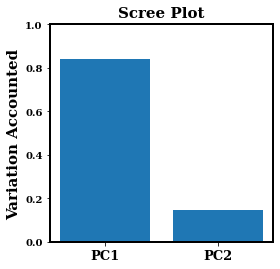

In [24]:
val = pca.explained_variance_ratio_

fig = plt.figure(figsize = (4, 4))
ax = plt.subplot(111)

plt.bar(range(len(val)), val)

plt.title("Scree Plot", fontsize = 15, y = 1.005, weight = "bold")
plt.ylabel("Variation Accounted", weight = "bold", fontsize = 15)
plt.ylim(0, 1)
ax.set_xticks(range(2)); ax.set_xticklabels(["PC1", "PC2"], fontsize = 13, weight = "bold")

plt.show()

In [25]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

#### By projecting down to 2D, we lost about 1.1% of the variance.
### 2D projection

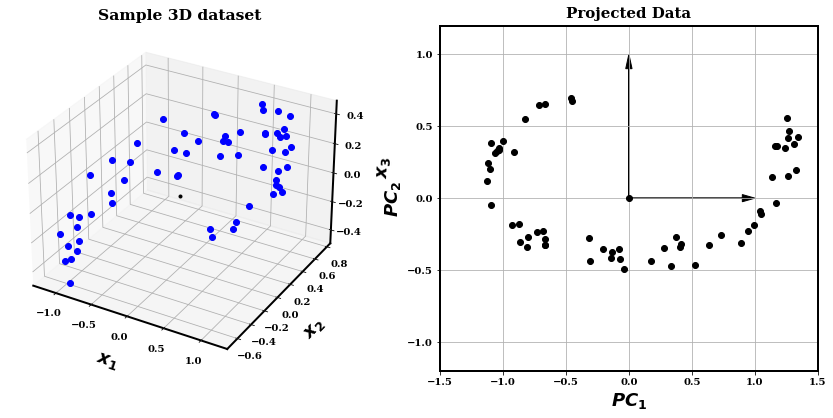

In [31]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(121, projection = '3d')

ax.plot(X[:, 0], X[:, 1], X[:, 2], "bo")
ax.plot([0], [0], [0], "k.")

ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)

ax.set_title("Sample 3D dataset", weight = "bold")

ax = plt.subplot(1, 2, 2)

ax.plot(X2D[:, 0], X2D[:, 1], "ko")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width = 0.05, length_includes_head = True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width = 0.05, length_includes_head = True, head_length=0.1, fc='k', ec='k')

ax.set_title("Projected Data", fontsize = 15, y = 1.005, weight = "bold")
ax.set_xlabel("$PC_1$", fontsize=18)
ax.set_ylabel("$PC_2$", fontsize=18)
ax.axis([-1.5, 1.5, -1.2, 1.2])
ax.grid(True)

plt.tight_layout()


### To what extent do we reduce dimension?

While ```n_components``` in ```PCA``` allows us to reduce the dimension to arbitrary value, **excessive reduction causes serious information loss from the data.**

We should use **the percentage of variation total PC accounts for** as a metric for measuring whether chosen dimension is low enough and containing enough information. (Usually, we'd like to preserve up to 95% variance)

#### Let's use the MNIST data as an example as it has larger number of features

In [32]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version = 1)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

#### PCA up to all components and plot cumulative scree plot

In [33]:
pca = PCA()
# does PCA on 784 componenets
pca.fit(X_train)
# plot the sumulative sum of varaince explained
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

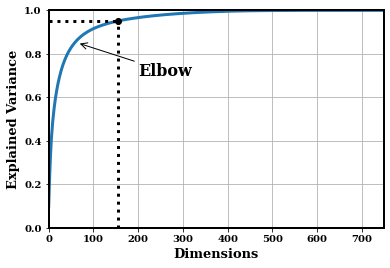

In [35]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth = 3)
plt.axis([0, 748, 0, 1])
plt.xlabel("Dimensions", weight = "bold")
plt.ylabel("Explained Variance", weight = "bold")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(200, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

#### tips: putting n_components = a float from 0.0 to 1.0 does pca to desired ```explained_variance_ratio_```

In [37]:
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)

pca.n_components_

154

#### Visualizing compressed data

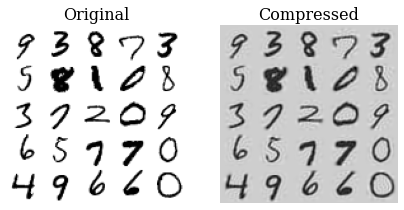

In [39]:
# see digits compressed and recovered
X_recovered = pca.inverse_transform(X_reduced)

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)
plt.show()

### Randomized PCA

*deploying stochastic algorithm to speed up PCA*

When using ```PCA``` from ```sklearn.decomposition```:

```n_components``` sets the dimension reducted

```svd_solver``` sets the algorithm for solving. By default, it is set to auto, using ```full``` - the full SVD approach if n is less than 500, or lower than 80% varaince explained; ```random``` calling the stochastic algorithm to speed up PCA

In [40]:
import time

# Running with full SVG
tic = time.time()
pca = PCA(n_components = 154, svd_solver = "full")
X_reduced = pca.fit_transform(X_train)
toc = time.time()

print("Running with full SVG: {:.2f}s".format(toc-tic))

Running with full SVG: 6.52s


In [41]:
import time

# Runining with Randomized PCA
tic = time.time()
pca = PCA(n_components = 154, svd_solver = "randomized")
X_reduced = pca.fit_transform(X_train)
toc = time.time()

print("Running with Randomized PCA: {:.2f}s".format(toc-tic))

Running with Randomized PCA: 3.53s


You can see **randomized PCA largely reduced training time**, useful for cases when dealing with **large amount of data.**

### Incremental PCA

*PCA with mini-batch*

- Useful when 
    - **running low on RAM**
    - **for large datasets**
    - **applying PCA on the fly**

In [83]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components = 154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end = "")
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

References:
   - Hands-On Machine Learning with Scikit-Learn and TensorFlow, Chap.8: Dimensionality Reduction (https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/)
   - Great Intro to PCA: https://youtu.be/FgakZw6K1QQ